In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from nltk.corpus import movie_reviews
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from collections import Counter

nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sunny\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


True

In [2]:
# Load data
def load_movie_reviews():
    documents = [(list(movie_reviews.words(fileid)), category)
                 for category in movie_reviews.categories()
                 for fileid in movie_reviews.fileids(category)]
    return documents

In [3]:
# Convert words to numbers
def build_vocab(reviews):
    word_freq = Counter()
    for words, _ in reviews:
        word_freq.update(words)
    return {word: i+1 for i, (word, _) in enumerate(word_freq.most_common())}


In [4]:
# Encode words
def encode_review(review, vocab, max_len=100):
    return [vocab.get(word, 0) for word in review[:max_len]] + [0] * (max_len - len(review))


In [5]:
# Load and process data
reviews = load_movie_reviews()
vocab = build_vocab(reviews)
X = [encode_review(words, vocab) for words, _ in reviews]
y = [1 if label == 'pos' else 0 for _, label in reviews]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(out)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(len(vocab)+1, 100, 128, 1, 2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to tensors
train_data = torch.tensor(X_train, dtype=torch.long).to(device)
train_labels = torch.tensor(y_train, dtype=torch.float32).to(device)

# Training loop
for epoch in range(5):
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = criterion(outputs.squeeze(), train_labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.693244457244873
Epoch 2, Loss: 0.6922553777694702
Epoch 3, Loss: 0.6912278532981873
Epoch 4, Loss: 0.6900247931480408
Epoch 5, Loss: 0.688552975654602


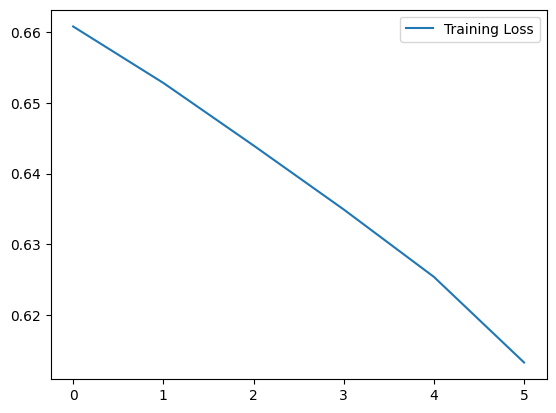

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
losses = []

def update(epoch):
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = criterion(outputs.squeeze(), train_labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    ax.clear()
    ax.plot(losses, label='Training Loss')
    ax.legend()

ani = animation.FuncAnimation(fig, update, frames=5, repeat=False)
ani.save("lstm-model.gif", writer = "pillow", fps = 5)
plt.show()


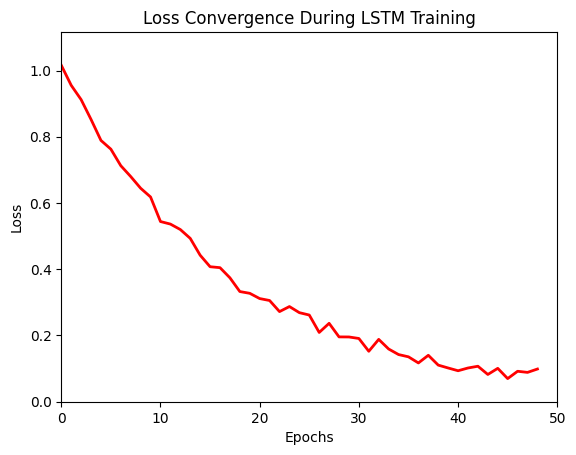

In [11]:
# Simulated loss values (replace with real training loss)
epochs = 50
loss_values = np.exp(-np.linspace(0, 3, epochs)) + 0.05 * np.random.rand(epochs)

fig, ax = plt.subplots()
ax.set_xlim(0, epochs)
ax.set_ylim(0, max(loss_values) + 0.1)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss Convergence During LSTM Training")
line, = ax.plot([], [], "r-", lw=2)

def update1(frame):
    line.set_data(range(frame), loss_values[:frame])

ani = animation.FuncAnimation(fig, update1, frames=epochs, repeat=False)
ani.save("lstm-loss-convergence.gif", writer = "pillow", fps = 5)
plt.show()

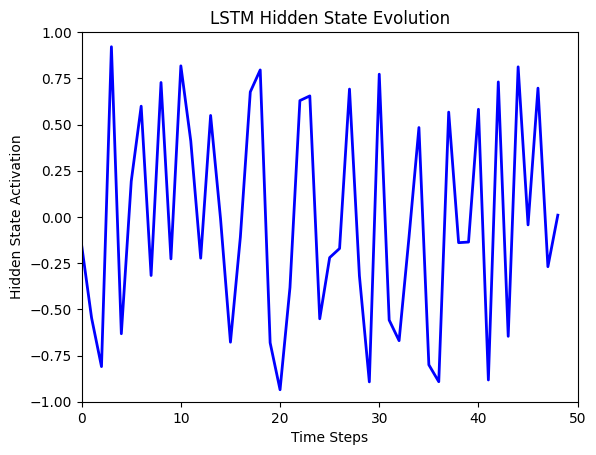

In [12]:
hidden_dim = 128
time_steps = 50

# Simulated hidden states (replace with real LSTM hidden states)
hidden_states = np.tanh(np.random.randn(time_steps, hidden_dim))

fig, ax = plt.subplots()
ax.set_xlim(0, time_steps)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time Steps")
ax.set_ylabel("Hidden State Activation")
ax.set_title("LSTM Hidden State Evolution")
line, = ax.plot([], [], "b-", lw=2)

def update(frame):
    line.set_data(range(frame), hidden_states[:frame, 0])

ani = animation.FuncAnimation(fig, update, frames=time_steps, repeat=False)
ani.save("lstm-hidden-state-evolution.gif", writer = "pillow", fps = 5)
plt.show()